## Necessary conditions for Graph partition 
### Install pyQUBO from Recruit Communications Co. Ltd.
    pip install pyqubo
### Install openJij from Jij Inc.  (startup from Tohoku University)
    pip install -U cmake (in google collaboratory, update cmake)
    pip install open jij

### Add networkx for dealing with graph theory

        pip install networkx

# Solve Graph Partition

### import pyQUBO, openJij and numpy

In [1]:
from pyqubo  import Array,Constraint, Placeholder
import openjij as jij
import numpy as np

Array, Constrains and Placeholders are convenient classes from pyQUBO

### import networkx

In [2]:
import networkx as nx

### Prepare some graph

In [3]:
nodes = [0, 1, 2, 3, 4, 5]
edges = [
    (0, 1), (1, 2), (2, 0), 
    (1, 5), (0, 3),
    (3, 4), (4, 5), (5, 1)
    ]

### Set nodes and edges on Graph G

In [4]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

In [5]:
import matplotlib.pyplot as plt
nx.draw_networkx(G)
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

### Prepare spin variables

In [6]:
N = 6
vartype = "SPIN"
x = Array.create("x",shape=N,vartype=vartype)

"x" is name of variables  
shape specifies the shape of variables as vector, matrix, or...  
vartype selects -1 or 1 by "SPIN" and 0 or 1by "BINARY"

In [7]:
print(x)

Array([Spin(x[0]), Spin(x[1]), Spin(x[2]), Spin(x[3]), Spin(x[4]), Spin(x[5])])


### Define cost function

In [8]:
E1 = Constraint((np.sum(x))**2,"equal")

In [9]:
E2 = 0
for e in edges:
    E2 += 0.5*(1-x[e[0]]*x[e[1]])

In [10]:
Lam = Placeholder('Lam')
E_cost = Lam*E1+E2

### Compile the cost function

In [11]:
model = E_cost.compile()

### Get qubo matrix

In [12]:
feed_dict = {'Lam': 5.0}
h,J, offset = model.to_ising(feed_dict=feed_dict)

### Prepare simulation of quantum annealing

In [13]:
sampler = jij.SQASampler(beta=10.0, gamma=1.0, trotter=4, step_length=10, step_num=100, schedule=None, iteration=1)

This is done by quantum Monte-Carlo simulation  
gamma = strength of quantum fluctuation  
iteration = number of reads  
step_num = number of MCS  
trotter = Trotter number  
step_length = length of MCS in the same gamma   

### Let's simulate quantum annealing

In [14]:
response = sampler.sample_ising(h,J)

### Show results

In [15]:
print(response)

iteration : 1, minimum energy : -31.0, var_type : SPIN
indices: ['x[1]', 'x[4]', 'x[5]', 'x[2]', 'x[0]', 'x[3]'] 
minmum energy state sample : [1, 1, 1, -1, -1, -1]


### minimum sample

In [16]:
response.samples[0]

{'x[1]': 1, 'x[4]': 1, 'x[5]': 1, 'x[2]': -1, 'x[0]': -1, 'x[3]': -1}

### decode solution through openJij and pyQUBO

In [20]:
def decode_spin(sol,vartype,feed_dict = None):
    dsol, broken, energy = model.decode_solution(sol, feed_dict = feed_dict, vartype=vartype)
    spin = np.zeros(N)
    for keys in dsol["x"]:
        spin[keys] = dsol["x"][keys]
    return spin,energy,broken

We define an original function for decoding the solution from openJij with pyQUBO into a standard expression.  
reposense.min["min_state"] is written on the indices in openJij.
Here we arrange the original order of the variables by our function.

In [21]:
spin,energy,broken = decode_spin(response.samples[0],vartype=vartype,feed_dict = feed_dict)

### check constraints

In [22]:
print(broken)

{}


### show resulting graph

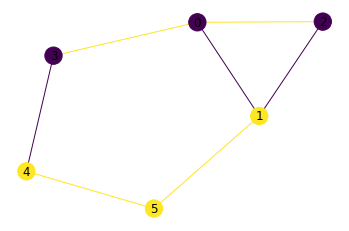

In [23]:
edge_colors = [spin[edge[0]]*spin[edge[1]] >0 for edge in G.edges()]
node_colors = [spin[node]>0 for node in G.nodes()]

nx.draw_networkx(G,node_color=node_colors,edge_color=edge_colors)
plt.axis("off")
plt.show()